In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

## Data Preprocessing

In [2]:
train_df = pd.read_json('train.jsonl', lines=True)
X_train = train_df['string']
y_train = train_df['label']

dev_df = pd.read_json('dev.jsonl', lines=True)
X_dev = dev_df['string']
y_dev = dev_df['label']

test_df = pd.read_json('test.jsonl', lines=True)
X_test = test_df['string']
y_test = test_df['label']

train_df

,source,citeEnd,sectionName,citeStart,string,label,label_confidence,citingPaperId,citedPaperId,isKeyCitation,id,unique_id,excerpt_index,label2,label2_confidence
0,explicit,175.0,Introduction,168.0,"However, how frataxin interacts with the Fe-S ...",background,1.0000,1872080baa7d30ec8fb87be9a65358cd3a7fb649,894be9b4ea46a5c422e81ef3c241072d4c73fdc0,True,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,11,NaN,NaN
1,explicit,36.0,Novel Quantitative Trait Loci for Seminal Root...,16.0,"In the study by Hickey et al. (2012), spikes w...",background,1.0000,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b,b6642e19efb8db5623b3cc4eef1c5822a6151107,True,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,2,NaN,NaN
2,explicit,228.0,Introduction,225.0,"The drug also reduces catecholamine secretion,...",background,1.0000,9cdf605beb1aa1078f235c4332b3024daa8b31dc,4e6a17fb8d7a3cada601d942e22eb5da6d01adbd,False,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,0,NaN,NaN
3,explicit,110.0,Discussion,46.0,By clustering with lowly aggressive close kin ...,background,1.0000,d9f3207db0c79a3b154f3875c9760cc6b056904b,2cc6ff899bf17666ad35893524a4d61624555ed7,False,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,3,NaN,NaN
4,explicit,239.0,Discussion,234.0,Ophthalmic symptoms are rare manifestations of...,background,1.0000,88b86556857f4374842d2af2e359576806239175,a5bb0ff1a026944d2a47a155462959af2b8505a8,False,88b86556857f4374842d2af2e359576806239175>a5bb0...,88b86556857f4374842d2af2e359576806239175>a5bb0...,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8238,explicit,50.0,,28.0,"Importantly, the results of Pascalis et al. (2...",background,0.7350,6f68ccd37718366c40ae6aeedf0b935bf560b215,60ed4bdabf92b2fbd6162dbd8979888cccca55d7,True,6f68ccd37718366c40ae6aeedf0b935bf560b215>60ed4...,6f68ccd37718366c40ae6aeedf0b935bf560b215>60ed4...,15,NaN,NaN
8239,explicit,182.0,DISCUSSION,179.0,"As suggested by Nguena et al, there is a need ...",background,0.7508,f2a1c1704f9587c94ed95bc98179dc499e933f5e,574e659da7f6c62c07bfaaacd1f31d65bd75524c,True,f2a1c1704f9587c94ed95bc98179dc499e933f5e>574e6...,f2a1c1704f9587c94ed95bc98179dc499e933f5e>574e6...,1,NaN,NaN
8240,explicit,120.0,DISCUSSION,108.0,Skeletal muscle is also a primary site of dise...,background,1.0000,18c97ea2ff60c110cc2a523e0fdf729608cbb083,fc13b9c3dfcc121013edaa12fa8ce7842aaed21a,False,18c97ea2ff60c110cc2a523e0fdf729608cbb083>fc13b...,18c97ea2ff60c110cc2a523e0fdf729608cbb083>fc13b...,8,NaN,NaN
8241,explicit,221.0,,185.0,ACTIVATION OF TRANSCRIPTION FACTORS Roles for ...,method,NaN,4ec9b89857c0b27e8a4bd3745b7358f387773527,81affdba19e38e2b17cf7b9e93792cc2028cf21d,True,4ec9b89857c0b27e8a4bd3745b7358f387773527>81aff...,4ec9b89857c0b27e8a4bd3745b7358f387773527>81aff...,0,NaN,NaN


In [3]:
X_train.isnull().sum()
X_test.isnull().sum()

0

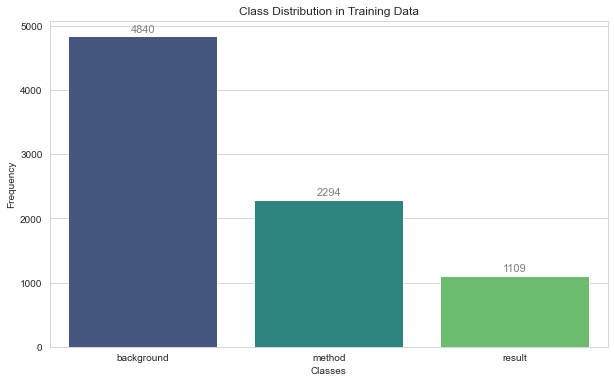

In [4]:
sns.set_style("whitegrid")

# Function to plot the class distribution with seaborn
def plot_class_distribution(y_train):
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=y_train, palette="viridis")
    plt.title('Class Distribution in Training Data')
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    
    # Add the count above the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='gray', xytext=(0, 7),
                    textcoords='offset points')
    
    # Show the plot
    plt.show()

# Plotting class distribution for y_train
plot_class_distribution(y_train)

In [5]:
def cleaning(text):
    stop_words = stopwords.words('english')
    text = text.lower()
    text = ' '.join(x for x in text.split() if x not in stop_words)
    return text

In [6]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    words = []
    for x in text.split():
        x = lemmatizer.lemmatize(x)
        words.append(x)
    text = ' '.join(words)
    return text

In [7]:
def preprocessing(text):
    # Tokenization
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
    text = cleaning(text)
    text = lemmatize(text)
    text = ' '.join(tokenizer.tokenize(text))
    return text

In [8]:
def augment_data_multiclass(X, y):
    df = pd.concat([X, y], axis=1)
    majority_class_size = df['label'].value_counts().max()
    upsampled_dataframes = []
    for class_label in df['label'].unique():
        class_df = df[df['label'] == class_label]
        if len(class_df) < majority_class_size:
            class_df_upsampled = resample(class_df, replace=True, n_samples=majority_class_size, random_state=10)
            upsampled_dataframes.append(class_df_upsampled)
        else:
            upsampled_dataframes.append(class_df)
    upsampled_df = pd.concat(upsampled_dataframes)
    return upsampled_df['string'], upsampled_df['label']

## Model Construction and Tuning

In [11]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score,accuracy_score

## Feature Extraction

### Baseline

In [12]:
vectorizer = TfidfVectorizer(preprocessor=preprocessing)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_dev_tfidf = vectorizer.transform(X_dev)
X_test_tfidf = vectorizer.transform(X_test)

In [13]:
baseline = MultinomialNB()
baseline.fit(X_train_tfidf.toarray(), y_train)
y_pred_baseline = baseline.predict(X_test_tfidf.toarray())
f1_score_base = f1_score(y_test, y_pred_baseline, average='macro')
acc_score_base= accuracy_score(y_test, y_pred_baseline)

In [14]:
acc_score_base

0.6131112305212252

In [15]:
f1_score_base

0.37970394885823383

### BOW Representation

In [9]:
#X_train, y_train = augment_data_multiclass(X_train, y_train)
cv = CountVectorizer(ngram_range=(1,1),preprocessor=preprocessing)
X_train_bow = cv.fit_transform(X_train)
X_dev_bow = cv.transform(X_dev)
X_test_bow = cv.transform(X_test)

### TF-IDF Representation

In [24]:
#X_train, y_train = augment_data_multiclass(X_train, y_train)
vectorizer = TfidfVectorizer(preprocessor=preprocessing, ngram_range=(1, 2), min_df=3, max_df=0.5, use_idf=True, smooth_idf=True)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_dev_tfidf = vectorizer.transform(X_dev)
X_test_tfidf = vectorizer.transform(X_test)

### Naive Bayes

Using the preprocessed data, we are able to run and process a simple Naive Bayes model.

In [16]:
# Calculating priors (P(y) = #documents of class y/#total documents)
def get_prior(class_name: str):
    class_docs_count = y_train.value_counts()[class_name]
    total_docs = y_train.count()

    return class_docs_count / total_docs

In [17]:
classes = y_train.unique()

priors = [get_prior(class_name) for class_name in classes]

In [18]:
'''model = GaussianNB()
parameters = {
    'priors': [priors, [0.5, 0.3, 0.2], [0.5, 0.2, 0.3], [0.6, 0.2, 0.2], [0.4, 0.3, 0.3]],
    'var_smoothing': [1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
}'''

"model = GaussianNB()\nparameters = {\n    'priors': [priors, [0.5, 0.3, 0.2], [0.5, 0.2, 0.3], [0.6, 0.2, 0.2], [0.4, 0.3, 0.3]],\n    'var_smoothing': [1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]\n}"

In [25]:
# BOW Representation x GaussianNB
GNB_model_BoW = GaussianNB(priors=priors)
GNB_model_BoW.fit(X_train_bow.toarray(), y_train)
#GNB_model_BoW = GridSearchCV(model, parameters)
y_pred_BoW_GNB = GNB_model_BoW.predict(X_test_bow.toarray())
f1_score_BoW_GNB = f1_score(y_test, y_pred_BoW_GNB, average='macro')
acc_score_BoW_GNB = accuracy_score(y_test, y_pred_BoW_GNB)

In [26]:
# BOW Representation x MultinomialNB
MNB_model_BoW = MultinomialNB()
MNB_model_BoW.fit(X_train_bow.toarray(), y_train)
y_pred_BoW_MNB= MNB_model_BoW.predict(X_test_bow.toarray())
f1_score_BoW_MNB= f1_score(y_test, y_pred_BoW_MNB, average='macro')
acc_score_BoW_MNB = accuracy_score(y_test, y_pred_BoW_MNB)

In [27]:
# TF-IDF Representation x GaussianNB
GNB_model_tfidf = GaussianNB(priors=priors)
GNB_model_tfidf.fit(X_train_tfidf.toarray(), y_train)
#GNB_model_tfidf = GridSearchCV(model, parameters)
y_pred_tfidf_GNB= GNB_model_tfidf.predict(X_test_tfidf.toarray())
f1_score_tfidf_GNB = f1_score(y_test, y_pred_tfidf_GNB, average='macro')
acc_score_tfidf_GNB = accuracy_score(y_test, y_pred_tfidf_GNB)

In [28]:
# TF-IDF Representation x MultinomialNB
MNB_model_tfidf = MultinomialNB()
MNB_model_tfidf.fit(X_train_tfidf.toarray(), y_train)
y_pred_tfidf_MNB = MNB_model_tfidf.predict(X_test_tfidf.toarray())
f1_score_tfidf_MNB = f1_score(y_test, y_pred_tfidf_MNB, average='macro')
acc_score_tfidf_MNB= accuracy_score(y_test, y_pred_tfidf_MNB)

Finally, compare the F1 scores and accuracy scores.

In [29]:
list1 = ["GNB x BOW", acc_score_BoW_GNB, f1_score_BoW_GNB]
list2 = ["MNB x BOW",acc_score_BoW_MNB, f1_score_BoW_MNB]
list3 = ["GNB x TFIDF", acc_score_tfidf_GNB, f1_score_tfidf_GNB]
list4 = ["MNB x TFIDF", acc_score_tfidf_MNB, f1_score_tfidf_MNB]

df = pd.DataFrame([list1, list2, list3, list4], columns=['Model','Accuracy', 'F1'])
df

,Model,Accuracy,F1
0,GNB x BOW,0.558302,0.469153
1,MNB x BOW,0.750134,0.682132
2,GNB x TFIDF,0.573348,0.507729
3,MNB x TFIDF,0.695325,0.543895


In [21]:
#print(f"F1 Score for BoW Naive-Bayes model: {f1_score_BoW}")
#print(f"Accuracy Score for BoW Naive-Bayes model: {acc_score_BoW}")
#print(f"F1 Score for TF-IDF Naive-Bayes model: {f1_score_tfidf}")
#print(f"Accuracy Score for TF-IDF Naive-Bayes model: {acc_score_tfidf}")

# Normal Gaussian Model with Priors
# F1 Score for BoW Naive-Bayes model: 0.4691528243483322
# F1 Score for TF-IDF Naive-Bayes model: 0.5077292892355515

# Multinomial NB
# F1 Score for BoW Naive-Bayes model: 0.6821318078269769
# F1 Score for TF-IDF Naive-Bayes model: 0.5438953105865063

# GridSearchCV for Gaussian NB (30+ minutes)
# F1 Score for BoW Naive-Bayes model: 0.4704550456140844
# F1 Score for TF-IDF Naive-Bayes model: 0.5077292892355515

MultinomialNB seems to perform better than GaussianNB. We'll try to optimize the hyperparameter of MultinomialNB using GridSearchCV

In [39]:
from sklearn.metrics import make_scorer

f1_macro_scorer = make_scorer(f1_score, average='macro')

parameters = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0],
    'fit_prior': [True, False]
}

bow_grid = GridSearchCV(MultinomialNB(), parameters, cv=5, scoring=f1_macro_scorer)
tfidf_grid = GridSearchCV(MultinomialNB(), parameters, cv=5, scoring=f1_macro_scorer)

In [40]:
bow_grid.fit(X_train_bow, y_train)
model_bow = bow_grid.best_estimator_

tfidf_grid.fit(X_train_tfidf, y_train)
model_tfidf = tfidf_grid.best_estimator_

In [41]:
y_pred_bow = model_bow.predict(X_test_bow)
f1_score_bow = f1_score(y_test, y_pred_bow, average='macro')
acc_score_bow = accuracy_score(y_test, y_pred_bow)

y_pred_tfidf = model_tfidf.predict(X_test_tfidf)
f1_score_tfidf = f1_score(y_test, y_pred_tfidf, average='macro')
acc_score_tfidf = accuracy_score(y_test, y_pred_tfidf)

In [42]:
print(f"F1 Score for hyper-optimized BoW Multinomial Naive-Bayes model: {f1_score_bow}")
print(f"Accuracy Score for hyper-optimized BoW Multinomial Naive-Bayes model: {acc_score_bow}")
print(f"F1 Score for hyper-optimized TF-IDF Multinomial Naive-Bayes model: {f1_score_tfidf}")
print(f"Accuracy Score for hyper-optimized TF-IDF Multinomial Naive-Bayes model: {acc_score_tfidf}")

F1 Score for hyper-optimized BoW Multinomial Naive-Bayes model: 0.7044097669097669
Accuracy Score for hyper-optimized BoW Multinomial Naive-Bayes model: 0.7490596453519613
F1 Score for hyper-optimized TF-IDF Multinomial Naive-Bayes model: 0.7261986278379723
Accuracy Score for hyper-optimized TF-IDF Multinomial Naive-Bayes model: 0.7587318645889307


In [43]:
list1 = ["MNB x BOW", acc_score_bow, f1_score_bow]
list2 = ["MNB x TFIDF", acc_score_tfidf, f1_score_tfidf]

df = pd.DataFrame([list1, list2], columns=['Model','Accuracy', 'F1'])
df

,Model,Accuracy,F1
0,MNB x BOW,0.749060,0.704410
1,MNB x TFIDF,0.758732,0.726199


In [47]:
# category 1
short_df = test_df[test_df['string'].apply(lambda x: len(nltk.word_tokenize(x)) <= 25)]
X_test1_bow = cv.transform(short_df['string'])
X_test1_tfidf = vectorizer.transform(short_df['string'])
y_test1 = short_df['label']
y_pred_bow = model_bow.predict(X_test1_bow)
f1_score_bow = f1_score(y_test1, y_pred_bow, average='macro')
acc_score_bow = accuracy_score(y_test1, y_pred_bow)

y_pred_tfidf = model_tfidf.predict(X_test1_tfidf)
f1_score_tfidf = f1_score(y_test1, y_pred_tfidf, average='macro')
acc_score_tfidf = accuracy_score(y_test1, y_pred_tfidf)
print(f"F1 Score on Category 1 for hyper-optimized BoW Multinomial Naive-Bayes model: {f1_score_bow}")
print(f"Accuracy Score on Category 1 for hyper-optimized BoW Multinomial Naive-Bayes model: {acc_score_bow}")
print(f"F1 Score on Category 1 for hyper-optimized TF-IDF Multinomial Naive-Bayes model: {f1_score_tfidf}")
print(f"Accuracy Score on Category 1 for hyper-optimized TF-IDF Multinomial Naive-Bayes model: {acc_score_tfidf}")

F1 Score on Category 1 for hyper-optimized BoW Multinomial Naive-Bayes model: 0.7481144509393096
Accuracy Score on Category 1 for hyper-optimized BoW Multinomial Naive-Bayes model: 0.7824427480916031
F1 Score on Category 1 for hyper-optimized TF-IDF Multinomial Naive-Bayes model: 0.7762221803488055
Accuracy Score on Category 1 for hyper-optimized TF-IDF Multinomial Naive-Bayes model: 0.7977099236641222


In [49]:
# category 2
long_df = test_df[test_df['string'].apply(lambda x: len(nltk.word_tokenize(x)) > 25)]
X_test2_bow = cv.transform(long_df['string'])
X_test2_tfidf = vectorizer.transform(long_df['string'])
y_test2 = long_df['label']
y_pred_bow = model_bow.predict(X_test2_bow)
f1_score_bow = f1_score(y_test2, y_pred_bow, average='macro')
acc_score_bow = accuracy_score(y_test2, y_pred_bow)

y_pred_tfidf = model_tfidf.predict(X_test2_tfidf)
f1_score_tfidf = f1_score(y_test2, y_pred_tfidf, average='macro')
acc_score_tfidf = accuracy_score(y_test2, y_pred_tfidf)
print(f"F1 Score on Category 2 for hyper-optimized BoW Multinomial Naive-Bayes model: {f1_score_bow}")
print(f"Accuracy Score on Category 2 for hyper-optimized BoW Multinomial Naive-Bayes model: {acc_score_bow}")
print(f"F1 Score on Category 2 for hyper-optimized TF-IDF Multinomial Naive-Bayes model: {f1_score_tfidf}")
print(f"Accuracy Score on Category 2 for hyper-optimized TF-IDF Multinomial Naive-Bayes model: {acc_score_tfidf}")

F1 Score on Category 2 for hyper-optimized BoW Multinomial Naive-Bayes model: 0.6969424572373052
Accuracy Score on Category 2 for hyper-optimized BoW Multinomial Naive-Bayes model: 0.7435897435897436
F1 Score on Category 2 for hyper-optimized TF-IDF Multinomial Naive-Bayes model: 0.7177891082831502
Accuracy Score on Category 2 for hyper-optimized TF-IDF Multinomial Naive-Bayes model: 0.7523452157598499


In [51]:
# category 3
paragraph_df = test_df[test_df['string'].apply(lambda x: len(nltk.sent_tokenize(x)) > 1)]
X_test3_bow = cv.transform(paragraph_df['string'])
X_test3_tfidf = vectorizer.transform(paragraph_df['string'])
y_test3 = paragraph_df['label']
y_pred_bow = model_bow.predict(X_test3_bow)
f1_score_bow = f1_score(y_test3, y_pred_bow, average='macro')
acc_score_bow = accuracy_score(y_test3, y_pred_bow)

y_pred_tfidf = model_tfidf.predict(X_test3_tfidf)
f1_score_tfidf = f1_score(y_test3, y_pred_tfidf, average='macro')
acc_score_tfidf = accuracy_score(y_test3, y_pred_tfidf)
print(f"F1 Score on Category 3 for hyper-optimized BoW Multinomial Naive-Bayes model: {f1_score_bow}")
print(f"Accuracy Score on Category 3 for hyper-optimized BoW Multinomial Naive-Bayes model: {acc_score_bow}")
print(f"F1 Score on Category 3 for hyper-optimized TF-IDF Multinomial Naive-Bayes model: {f1_score_tfidf}")
print(f"Accuracy Score on Category 3 for hyper-optimized TF-IDF Multinomial Naive-Bayes model: {acc_score_tfidf}")

F1 Score on Category 3 for hyper-optimized BoW Multinomial Naive-Bayes model: 0.7008253968253969
Accuracy Score on Category 3 for hyper-optimized BoW Multinomial Naive-Bayes model: 0.7481840193704601
F1 Score on Category 3 for hyper-optimized TF-IDF Multinomial Naive-Bayes model: 0.7525760915718184
Accuracy Score on Category 3 for hyper-optimized TF-IDF Multinomial Naive-Bayes model: 0.784503631961259


In [52]:
# category 4
def rearrange_letter(word):
    word_list = list(word)
    n = len(word_list)
    if n == 1:
        return ''.join(word_list)
    
    idx = random.randint(0, n - 2)
    word_list[idx], word_list[idx + 1] = word_list[idx + 1], word_list[idx]
    return ''.join(word_list)

def rearrange_word(text):
    words = nltk.word_tokenize(text)
    num_words = len(words)

    # rearrange letter for some random word
    for _ in range(5):
        idx = random.randint(0, num_words - 1)
        words[idx] = rearrange_letter(words[idx])
    
    # rearrange word
    for _ in range(min(3, num_words - 1)):
        idx = random.randint(0, num_words - 2)
        words[idx], words[idx + 1] = words[idx + 1], words[idx]

    return ' '.join(words)

typo_series = test_df['string'].apply(rearrange_word)

typo_df = pd.DataFrame({
    'label': test_df.label,
    'string': typo_series
})


X_test4_bow = cv.transform(typo_df['string'])
X_test4_tfidf = vectorizer.transform(typo_df['string'])
y_test4 = typo_df['label']
y_pred_bow = model_bow.predict(X_test4_bow)
f1_score_bow = f1_score(y_test4, y_pred_bow, average='macro')
acc_score_bow = accuracy_score(y_test4, y_pred_bow)

y_pred_tfidf = model_tfidf.predict(X_test4_tfidf)
f1_score_tfidf = f1_score(y_test4, y_pred_tfidf, average='macro')
acc_score_tfidf = accuracy_score(y_test4, y_pred_tfidf)
print(f"F1 Score on Category 4 for hyper-optimized BoW Multinomial Naive-Bayes model: {f1_score_bow}")
print(f"Accuracy Score on Category 4 for hyper-optimized BoW Multinomial Naive-Bayes model: {acc_score_bow}")
print(f"F1 Score on Category 4 for hyper-optimized TF-IDF Multinomial Naive-Bayes model: {f1_score_tfidf}")
print(f"Accuracy Score on Category 4 for hyper-optimized TF-IDF Multinomial Naive-Bayes model: {acc_score_tfidf}")

F1 Score on Category 4 for hyper-optimized BoW Multinomial Naive-Bayes model: 0.6823707537587823
Accuracy Score on Category 4 for hyper-optimized BoW Multinomial Naive-Bayes model: 0.7345513164965073
F1 Score on Category 4 for hyper-optimized TF-IDF Multinomial Naive-Bayes model: 0.7138380108247885
Accuracy Score on Category 4 for hyper-optimized TF-IDF Multinomial Naive-Bayes model: 0.7528210639441161


In [53]:
# category 5
synonymized_test_df = pd.read_json('synonymized.jsonl', lines=True)
synonymized_test_df = synonymized_test_df[['string', 'label']]
X_test5_bow = cv.transform(synonymized_test_df['string'])
X_test5_tfidf = vectorizer.transform(synonymized_test_df['string'])
y_test5 = synonymized_test_df['label']
y_pred_bow = model_bow.predict(X_test5_bow)
f1_score_bow = f1_score(y_test5, y_pred_bow, average='macro')
acc_score_bow = accuracy_score(y_test5, y_pred_bow)

y_pred_tfidf = model_tfidf.predict(X_test5_tfidf)
f1_score_tfidf = f1_score(y_test5, y_pred_tfidf, average='macro')
acc_score_tfidf = accuracy_score(y_test5, y_pred_tfidf)
print(f"F1 Score on Category 5 for hyper-optimized BoW Multinomial Naive-Bayes model: {f1_score_bow}")
print(f"Accuracy Score on Category 5 for hyper-optimized BoW Multinomial Naive-Bayes model: {acc_score_bow}")
print(f"F1 Score on Category 5 for hyper-optimized TF-IDF Multinomial Naive-Bayes model: {f1_score_tfidf}")
print(f"Accuracy Score on Category 5 for hyper-optimized TF-IDF Multinomial Naive-Bayes model: {acc_score_tfidf}")

F1 Score on Category 5 for hyper-optimized BoW Multinomial Naive-Bayes model: 0.5974853143014974
Accuracy Score on Category 5 for hyper-optimized BoW Multinomial Naive-Bayes model: 0.6985491671144546
F1 Score on Category 5 for hyper-optimized TF-IDF Multinomial Naive-Bayes model: 0.5960716107774932
Accuracy Score on Category 5 for hyper-optimized TF-IDF Multinomial Naive-Bayes model: 0.6899516389038152


In [54]:
# category 6
paraphrased_test_df = pd.read_json('paraphrased.jsonl', lines=True)
paraphrased_test_df = paraphrased_test_df[['string', 'label']]
X_test6_bow = cv.transform(paraphrased_test_df['string'])
X_test6_tfidf = vectorizer.transform(paraphrased_test_df['string'])
y_test6 = paraphrased_test_df['label']
y_pred_bow = model_bow.predict(X_test6_bow)
f1_score_bow = f1_score(y_test6, y_pred_bow, average='macro')
acc_score_bow = accuracy_score(y_test6, y_pred_bow)

y_pred_tfidf = model_tfidf.predict(X_test6_tfidf)
f1_score_tfidf = f1_score(y_test6, y_pred_tfidf, average='macro')
acc_score_tfidf = accuracy_score(y_test6, y_pred_tfidf)
print(f"F1 Score on Category 6 for hyper-optimized BoW Multinomial Naive-Bayes model: {f1_score_bow}")
print(f"Accuracy Score on Category 6 for hyper-optimized BoW Multinomial Naive-Bayes model: {acc_score_bow}")
print(f"F1 Score on Category 6 for hyper-optimized TF-IDF Multinomial Naive-Bayes model: {f1_score_tfidf}")
print(f"Accuracy Score on Category 6 for hyper-optimized TF-IDF Multinomial Naive-Bayes model: {acc_score_tfidf}")

F1 Score on Category 6 for hyper-optimized BoW Multinomial Naive-Bayes model: 0.6966951844085102
Accuracy Score on Category 6 for hyper-optimized BoW Multinomial Naive-Bayes model: 0.7415368081676518
F1 Score on Category 6 for hyper-optimized TF-IDF Multinomial Naive-Bayes model: 0.7191266193277633
Accuracy Score on Category 6 for hyper-optimized TF-IDF Multinomial Naive-Bayes model: 0.753895754970446


#### Logistic Regression

In [55]:
from sklearn.linear_model import LogisticRegression

In [56]:
logreg = LogisticRegression(max_iter=1000)

param_grid = {
    'C': [0.1, 1, 10], 
    'penalty': ['l1', 'l2','none'],
    'solver': ['liblinear', 'saga','sag']
}

In [57]:
f1_macro_scorer = make_scorer(f1_score, average='macro')
bow_grid = GridSearchCV(logreg, param_grid, cv=5, scoring=f1_macro_scorer, n_jobs=-1)
tfidf_grid = GridSearchCV(logreg, param_grid, cv=5, scoring=f1_macro_scorer, n_jobs=-1)

In [58]:
bow_grid.fit(X_train_bow, y_train)
model_bow = bow_grid.best_estimator_

tfidf_grid.fit(X_train_tfidf, y_train)
model_tfidf = tfidf_grid.best_estimator_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
Valu

In [59]:
y_pred_bow = model_bow.predict(X_test_bow)
f1_score_bow = f1_score(y_test, y_pred_bow, average='macro')
acc_score_bow = accuracy_score(y_test, y_pred_bow)

y_pred_tfidf = model_tfidf.predict(X_test_tfidf)
f1_score_tfidf = f1_score(y_test, y_pred_tfidf, average='macro')
acc_score_tfidf = accuracy_score(y_test, y_pred_tfidf)

In [60]:
list1 = ["LR x BOW", acc_score_bow, f1_score_bow]
list2 = ["LR x TFIDF", acc_score_tfidf, f1_score_tfidf]

df = pd.DataFrame([list1, list2], columns=['Model','Accuracy', 'F1'])
df

,Model,Accuracy,F1
0,LR x BOW,0.777002,0.747259
1,LR x TFIDF,0.775390,0.749791


In [63]:
# category 1
short_df = test_df[test_df['string'].apply(lambda x: len(nltk.word_tokenize(x)) <= 25)]
X_test1_bow = cv.transform(short_df['string'])
X_test1_tfidf = vectorizer.transform(short_df['string'])
y_test1 = short_df['label']
y_pred_bow = model_bow.predict(X_test1_bow)
f1_score_bow = f1_score(y_test1, y_pred_bow, average='macro')
acc_score_bow = accuracy_score(y_test1, y_pred_bow)

y_pred_tfidf = model_tfidf.predict(X_test1_tfidf)
f1_score_tfidf = f1_score(y_test1, y_pred_tfidf, average='macro')
acc_score_tfidf = accuracy_score(y_test1, y_pred_tfidf)
print(f"F1 Score on Category 1 for hyper-optimized BoW LR model: {f1_score_bow}")
print(f"Accuracy Score on Category 1 for hyper-optimized BoW LR model: {acc_score_bow}")
print(f"F1 Score on Category 1 for hyper-optimized TF-IDF LR model: {f1_score_tfidf}")
print(f"Accuracy Score on Category 1 for hyper-optimized TF-IDF LR model: {acc_score_tfidf}")

F1 Score on Category 1 for hyper-optimized BoW LR model: 0.7836713621948522
Accuracy Score on Category 1 for hyper-optimized BoW LR model: 0.8053435114503816
F1 Score on Category 1 for hyper-optimized TF-IDF LR model: 0.7712119855552572
Accuracy Score on Category 1 for hyper-optimized TF-IDF LR model: 0.7938931297709924


In [62]:
# category 2
long_df = test_df[test_df['string'].apply(lambda x: len(nltk.word_tokenize(x)) > 25)]
X_test2_bow = cv.transform(long_df['string'])
X_test2_tfidf = vectorizer.transform(long_df['string'])
y_test2 = long_df['label']
y_pred_bow = model_bow.predict(X_test2_bow)
f1_score_bow = f1_score(y_test2, y_pred_bow, average='macro')
acc_score_bow = accuracy_score(y_test2, y_pred_bow)

y_pred_tfidf = model_tfidf.predict(X_test2_tfidf)
f1_score_tfidf = f1_score(y_test2, y_pred_tfidf, average='macro')
acc_score_tfidf = accuracy_score(y_test2, y_pred_tfidf)
print(f"F1 Score on Category 2 for hyper-optimized BoW LR model: {f1_score_bow}")
print(f"Accuracy Score on Category 2 for hyper-optimized BoW LR model: {acc_score_bow}")
print(f"F1 Score on Category 2 for hyper-optimized TF-IDF LR model: {f1_score_tfidf}")
print(f"Accuracy Score on Category 2 for hyper-optimized TF-IDF LR model: {acc_score_tfidf}")

F1 Score on Category 2 for hyper-optimized BoW LR model: 0.7416599987247778
Accuracy Score on Category 2 for hyper-optimized BoW LR model: 0.7723577235772358
F1 Score on Category 2 for hyper-optimized TF-IDF LR model: 0.7463055914827872
Accuracy Score on Category 2 for hyper-optimized TF-IDF LR model: 0.7723577235772358


In [65]:
# category 3
paragraph_df = test_df[test_df['string'].apply(lambda x: len(nltk.sent_tokenize(x)) > 1)]
X_test3_bow = cv.transform(paragraph_df['string'])
X_test3_tfidf = vectorizer.transform(paragraph_df['string'])
y_test3 = paragraph_df['label']
y_pred_bow = model_bow.predict(X_test3_bow)
f1_score_bow = f1_score(y_test3, y_pred_bow, average='macro')
acc_score_bow = accuracy_score(y_test3, y_pred_bow)

y_pred_tfidf = model_tfidf.predict(X_test3_tfidf)
f1_score_tfidf = f1_score(y_test3, y_pred_tfidf, average='macro')
acc_score_tfidf = accuracy_score(y_test3, y_pred_tfidf)
print(f"F1 Score on Category 3 for hyper-optimized BoW LR model: {f1_score_bow}")
print(f"Accuracy Score on Category 3 for hyper-optimized BoW LR model: {acc_score_bow}")
print(f"F1 Score on Category 3 for hyper-optimized TF-IDF LR model: {f1_score_tfidf}")
print(f"Accuracy Score on Category 3 for hyper-optimized TF-IDF LR model: {acc_score_tfidf}")

F1 Score on Category 3 for hyper-optimized BoW LR model: 0.779450397097456
Accuracy Score on Category 3 for hyper-optimized BoW LR model: 0.801452784503632
F1 Score on Category 3 for hyper-optimized TF-IDF LR model: 0.7661167919620907
Accuracy Score on Category 3 for hyper-optimized TF-IDF LR model: 0.7869249394673123


In [67]:
# category 4
def rearrange_letter(word):
    word_list = list(word)
    n = len(word_list)
    if n == 1:
        return ''.join(word_list)
    
    idx = random.randint(0, n - 2)
    word_list[idx], word_list[idx + 1] = word_list[idx + 1], word_list[idx]
    return ''.join(word_list)

def rearrange_word(text):
    words = nltk.word_tokenize(text)
    num_words = len(words)

    # rearrange letter for some random word
    for _ in range(5):
        idx = random.randint(0, num_words - 1)
        words[idx] = rearrange_letter(words[idx])
    
    # rearrange word
    for _ in range(min(3, num_words - 1)):
        idx = random.randint(0, num_words - 2)
        words[idx], words[idx + 1] = words[idx + 1], words[idx]

    return ' '.join(words)

typo_series = test_df['string'].apply(rearrange_word)

typo_df = pd.DataFrame({
    'label': test_df.label,
    'string': typo_series
})


X_test4_bow = cv.transform(typo_df['string'])
X_test4_tfidf = vectorizer.transform(typo_df['string'])
y_test4 = typo_df['label']
y_pred_bow = model_bow.predict(X_test4_bow)
f1_score_bow = f1_score(y_test4, y_pred_bow, average='macro')
acc_score_bow = accuracy_score(y_test4, y_pred_bow)

y_pred_tfidf = model_tfidf.predict(X_test4_tfidf)
f1_score_tfidf = f1_score(y_test4, y_pred_tfidf, average='macro')
acc_score_tfidf = accuracy_score(y_test4, y_pred_tfidf)
print(f"F1 Score on Category 4 for hyper-optimized BoW LR model: {f1_score_bow}")
print(f"Accuracy Score on Category 4 for hyper-optimized BoW LR model: {acc_score_bow}")
print(f"F1 Score on Category 4 for hyper-optimized TF-IDF LR model: {f1_score_tfidf}")
print(f"Accuracy Score on Category 4 for hyper-optimized TF-IDF LR model: {acc_score_tfidf}")

F1 Score on Category 4 for hyper-optimized BoW LR model: 0.7171577760862927
Accuracy Score on Category 4 for hyper-optimized BoW LR model: 0.7522837184309511
F1 Score on Category 4 for hyper-optimized TF-IDF LR model: 0.7252373419658843
Accuracy Score on Category 4 for hyper-optimized TF-IDF LR model: 0.7565824825362708


In [68]:
# category 5
synonymized_test_df = pd.read_json('synonymized.jsonl', lines=True)
synonymized_test_df = synonymized_test_df[['string', 'label']]
X_test5_bow = cv.transform(synonymized_test_df['string'])
X_test5_tfidf = vectorizer.transform(synonymized_test_df['string'])
y_test5 = synonymized_test_df['label']
y_pred_bow = model_bow.predict(X_test5_bow)
f1_score_bow = f1_score(y_test5, y_pred_bow, average='macro')
acc_score_bow = accuracy_score(y_test5, y_pred_bow)

y_pred_tfidf = model_tfidf.predict(X_test5_tfidf)
f1_score_tfidf = f1_score(y_test5, y_pred_tfidf, average='macro')
acc_score_tfidf = accuracy_score(y_test5, y_pred_tfidf)
print(f"F1 Score on Category 5 for hyper-optimized BoW LR model: {f1_score_bow}")
print(f"Accuracy Score on Category 5 for hyper-optimized BoW LR model: {acc_score_bow}")
print(f"F1 Score on Category 5 for hyper-optimized TF-IDF LR model: {f1_score_tfidf}")
print(f"Accuracy Score on Category 5 for hyper-optimized TF-IDF LR model: {acc_score_tfidf}")

F1 Score on Category 5 for hyper-optimized BoW LR model: 0.546107527399177
Accuracy Score on Category 5 for hyper-optimized BoW LR model: 0.6646963997850618
F1 Score on Category 5 for hyper-optimized TF-IDF LR model: 0.5502410169196551
Accuracy Score on Category 5 for hyper-optimized TF-IDF LR model: 0.6695325094035465


In [69]:
# category 6
paraphrased_test_df = pd.read_json('paraphrased.jsonl', lines=True)
paraphrased_test_df = paraphrased_test_df[['string', 'label']]
X_test6_bow = cv.transform(paraphrased_test_df['string'])
X_test6_tfidf = vectorizer.transform(paraphrased_test_df['string'])
y_test6 = paraphrased_test_df['label']
y_pred_bow = model_bow.predict(X_test6_bow)
f1_score_bow = f1_score(y_test6, y_pred_bow, average='macro')
acc_score_bow = accuracy_score(y_test6, y_pred_bow)

y_pred_tfidf = model_tfidf.predict(X_test6_tfidf)
f1_score_tfidf = f1_score(y_test6, y_pred_tfidf, average='macro')
acc_score_tfidf = accuracy_score(y_test6, y_pred_tfidf)
print(f"F1 Score on Category 6 for hyper-optimized BoW LR model: {f1_score_bow}")
print(f"Accuracy Score on Category 6 for hyper-optimized BoW LR model: {acc_score_bow}")
print(f"F1 Score on Category 6 for hyper-optimized TF-IDF LR model: {f1_score_tfidf}")
print(f"Accuracy Score on Category 6 for hyper-optimized TF-IDF LR model: {acc_score_tfidf}")

F1 Score on Category 6 for hyper-optimized BoW LR model: 0.7289224201731997
Accuracy Score on Category 6 for hyper-optimized BoW LR model: 0.7603439011284255
F1 Score on Category 6 for hyper-optimized TF-IDF LR model: 0.7321209819086806
Accuracy Score on Category 6 for hyper-optimized TF-IDF LR model: 0.7603439011284255
